# CME 241 (Winter 2021) -- Assignment 12

In [13]:
from collections import defaultdict, deque
from typing import Iterable, TypeVar, Mapping, Dict, List, Set
import itertools as it

import matplotlib.pyplot as plt

from rl.chapter10.random_walk_mrp import RandomWalkMRP
from rl.distribution import Choose
from rl.markov_process import TransitionStep

## Question 1

In [2]:
S = TypeVar("S")

def n_step_bootstrapping(
    *,
    traces: Iterable[Iterable[TransitionStep[S]]],
    n: int,
    alpha: float,
    gamma: float,
    num_simulations: int = 500,
) -> Mapping[S, float]:
    """Implement the n-step bootsrapping prediction algorithm."""
    v: Dict[S, float] = defaultdict(float)
        
    def bootstrapped_return(_seq: deque) -> float:
        """Compute the bootstrapped return of a sequence."""
        G = 0.0
        for i in range(n - 1):
            G += pow(gamma, i) * _seq[i].reward
        return G + pow(gamma, n) * v[_seq[-1].state]
    
    def regular_return(_seq: List[S]) -> float:
        """Compute regular return for a sequence."""
        G = 0.0
        for j in range(len(_seq)):
            G += pow(gamma, j) * _seq[j].reward
        return G
        
    for sim in it.islice(traces, num_simulations):
        # for memory efficiency, only store n steps
        seq = deque(maxlen=n)
        for s in sim:
            seq.append(s)
            if len(seq) == n:
                state = seq[0].state
                v[state] += alpha * (bootstrapped_return(seq) - v[state])
                
        # for the remaining, it's just regular return
        rem = list(seq)
        for i in range(len(rem)):
            state = rem[i].state
            v[state] += alpha * (regular_return(rem[i:]) - v[state])
    return v

## Question 2

In [3]:
def td_lambda(
    *,
    traces: Iterable[Iterable[TransitionStep[S]]],
    nonterminal_states: Set[S],
    alpha: float,
    gamma: float,
    Lambda: float,
    num_simulations: int = 500,
) -> Mapping[S, float]:
    """Implement the TD(lambda) RL algorithm."""
    v: Dict[S, float] = defaultdict(float)
    
    for simulation in it.islice(traces, num_simulations):
        E = {s: 0 for s in nonterminal_states}
        for tstep in simulation:
            state = tstep.state
            next_state = tstep.next_state
            reward = tstep.reward
            
            for s in E:
                E[s] *= gamma * Lambda
                if state == s:
                    E[s] += 1

            for s in nonterminal_states:
                td_error = reward + gamma * v[next_state] - v[state]
                v[s] += alpha * td_error * E[s]
    return v

## Question 4

In [28]:
B = 20
p = 0.5

alpha = 0.1
gamma = 1

mrp = RandomWalkMRP(B, p)

# start our traces anywhere except a terminal state
seed = Choose(set(range(1, B)))

In [29]:
n_step = n_step_bootstrapping(
    traces=mrp.reward_traces(seed), 
    n=8,
    alpha=alpha,
    gamma=gamma
)
n_step

defaultdict(float,
            {3: 0.10744981450989963,
             6: 0.26112727131809965,
             4: 0.10859654806364069,
             7: 0.3817512052721492,
             5: 0.1594264932688159,
             8: 0.4143326814433998,
             9: 0.4630025486395416,
             10: 0.5726619388293431,
             11: 0.6607009092609729,
             12: 0.738992603985011,
             13: 0.7873975335627748,
             14: 0.8534396576179895,
             15: 0.9053951307292847,
             16: 0.9279850341213957,
             17: 0.9505500541517553,
             18: 0.9693544218202577,
             19: 0.9776749173216931,
             2: 0.051140422619403,
             1: 0.021565861389009337})

In [30]:
N = {s for s in mrp.states() if not mrp.is_terminal(s)}

td = td_lambda(
    traces=mrp.reward_traces(seed), 
    nonterminal_states=N,
    alpha=alpha,
    gamma=gamma,
    Lambda=0.5
)
td

defaultdict(float,
            {7: 0.309150039139379,
             8: 0.3640365320608962,
             1: 0.03448437224107659,
             2: 0.08149237481251569,
             3: 0.12155283341275659,
             4: 0.17672828198338464,
             5: 0.2288313213382301,
             6: 0.2735235898337338,
             9: 0.46646001962897515,
             10: 0.5103462452391297,
             11: 0.5488319099023082,
             12: 0.624595041060178,
             13: 0.7010139445548078,
             14: 0.7494907817068696,
             15: 0.7802604182390799,
             16: 0.8239388096076099,
             17: 0.867068376374624,
             18: 0.9049828195676493,
             19: 0.9548850702023444,
             0: 0.0,
             20: 0.0})

In [31]:
matrix = mrp.get_value_function_vec(gamma=gamma)
matrix

array([0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55,
       0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95])

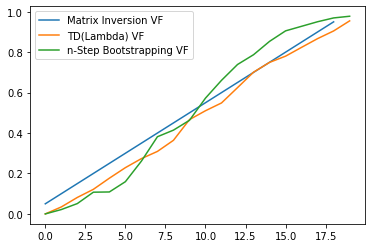

In [33]:
plt.plot(matrix, label="Matrix Inversion VF")
plt.plot(range(B), [td[i] for i in range(B)], label="TD(Lambda) VF")
plt.plot(range(B), [n_step[i] for i in range(B)], 
         label="n-Step Bootstrapping VF")

plt.legend()
plt.show()